Connected to pinns_opf (Python 3.9.17)

Epoch 1/100 - Cost: 8.1953
Epoch 2/100 - Cost: 3.6076
Epoch 3/100 - Cost: 2.9557
Epoch 4/100 - Cost: 1.4303
Epoch 5/100 - Cost: 0.7568
Epoch 6/100 - Cost: 0.7073
Epoch 7/100 - Cost: 0.2543
Epoch 8/100 - Cost: 0.2860
Epoch 9/100 - Cost: 0.2731
Epoch 10/100 - Cost: 0.3890
Epoch 11/100 - Cost: 0.2743
Epoch 12/100 - Cost: 0.2774
Epoch 13/100 - Cost: 0.2693
Epoch 14/100 - Cost: 0.2542
Epoch 15/100 - Cost: 0.2208
Epoch 16/100 - Cost: 0.2080
Epoch 17/100 - Cost: 0.2109
Epoch 18/100 - Cost: 0.1882
Epoch 19/100 - Cost: 0.2068
Epoch 20/100 - Cost: 0.1958
Epoch 21/100 - Cost: 0.1694
Epoch 22/100 - Cost: 0.1655
Epoch 23/100 - Cost: 0.1691
Epoch 24/100 - Cost: 0.1578
Epoch 25/100 - Cost: 0.1565
Epoch 26/100 - Cost: 0.1707
Epoch 27/100 - Cost: 0.1738
Epoch 28/100 - Cost: 0.1498
Epoch 29/100 - Cost: 0.1386
Epoch 30/100 - Cost: 0.1336
Epoch 31/100 - Cost: 0.1281
Epoch 32/100 - Cost: 0.1226
Epoch 33/100 - Cost: 0.1179
Epoch 34/100 - Cost: 0.1155
Epoch 35/100 - Cost: 0.1125
Epoch 36/100 - Cost: 0.1055
E

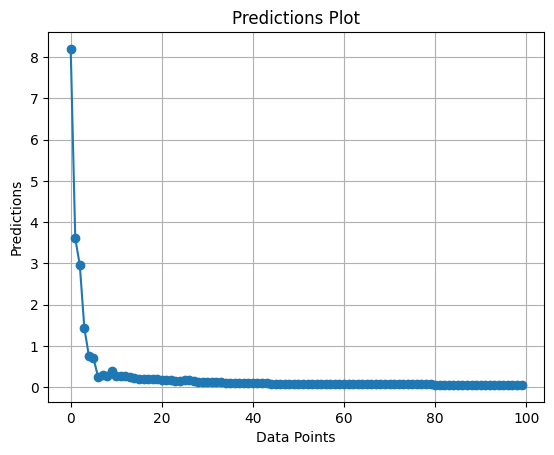

In [1]:
import os
os.chdir(os.path.dirname(os.path.abspath(__file__)))
import sys
import pickle
import logging
import time
import torch
import torch.nn.functional as F
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split
import matplotlib.pyplot as plt
from model import RecurrentGCN
from utilities import pinns_loss 
def train_model(lr, batch_size, epochs, pinns_loss, _lambda):
    start_time = time.time()
    # Create and configure logger
    logging.basicConfig(filename="std.log", format='%(asctime)s %(message)s', filemode='w')
    # Create an object
    logger = logging.getLogger()
    # Set log level to DEBUG
    logger.setLevel(logging.DEBUG)
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.DEBUG)
    # GPU support
    DEVICE = torch.device('cpu')  # Change to cuda if available
    shuffle = True
    # Change the current working directory to the script's directory
    os.chdir(os.path.dirname(os.path.abspath(__file__)))
    # Load the data from the pickle file
    with open('../../data/processed/data_converged_noise.pickle', 'rb') as file:
        loaded_data = pickle.load(file)
    # Access the loaded data
    edge_index = loaded_data['edge_index']
    edge_weight = loaded_data['edge_weight']
    features_seq = loaded_data['features_seq']
    targets_seq = loaded_data['targets_seq']
    dataset = StaticGraphTemporalSignal(
        edge_index=edge_index, edge_weight=edge_weight,
        features=features_seq, targets=targets_seq
    )
    train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)
    model = RecurrentGCN(node_features=9)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    n = 5  # number of nodes
    v_lower = torch.ones((n, 1))*0.93
    v_upper = torch.ones((n, 1))*1.07
    costs, model_path = model._train(model, train_dataset=train_dataset, epochs=epochs, lr=lr, h=None, c=None, pinns_loss=pinns_loss,  _lambda=_lambda, v_lower=v_lower, v_upper=v_upper)
    print(f"Training completed in {time.time() - start_time:.2f} seconds.")
    return costs, model_path

if __name__ == "__main__":
    learning_rate = 0.05
    batch_size = 32
    num_epochs = 100
    _lambda = 0.3
    costs, model_path = train_model(lr=learning_rate, batch_size=batch_size, epochs=num_epochs, pinns_loss=pinns_loss, _lambda=_lambda)
    # Plot the predictions
    plt.plot(range(len(costs)), costs, marker='o', linestyle='-')
    plt.xlabel('Data Points')
    plt.ylabel('Predictions')
    plt.title('Predictions Plot')
    plt.grid(True)
    plt.show()
    with open('costs_pinns_100.pkl', 'wb') as f:
        pickle.dump(costs, f)